In [1]:
# analyze the session logs from the IPE user study
import numpy as np
import codecs
import re
import json
import os
import copy
import difflib

from collections import defaultdict, Counter

%load_ext autoreload
%autoreload 2

In [2]:
participant_project_settings = {
    'P38': {
        'BASIC': 1,
        'QE': 2,
        'CD': 3,
        'IPE': 4
    },
    'P92': {
        'BASIC': 2,
        'QE': 3,
        'CD': 4,
        'IPE': 1
    },
    'P93': {
        'BASIC': 3,
        'QE': 4,
        'CD': 1,
        'IPE': 2 
    },
    'P94': {
        'BASIC': 4,
        'QE': 1,
        'CD': 2,
        'IPE': 3 
    },
    'P81': {
        'BASIC': 1,
        'QE': 2,
        'CD': 4,
        'IPE': 3
    }
}

In [3]:
LOG_DIR='/home/chris/Desktop/Dropbox/projects/handycat_interactive_pe/user_study_logs'

In [4]:

# Now make a map from participants to all of thier log files 
# Because of the way we collect logs, projects may be duplicated across multiple logfiles for a participant
def logdir_to_participant_log_map(logdir):
    task_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4}
    participant_logfiles = defaultdict(list)
    for participant_id in os.listdir(logdir):
        print('id: {}'.format(participant_id))
        for item in os.listdir(os.path.join(logdir, participant_id)):
            if item.endswith('.json'):
                participant_logfiles[participant_id].append(os.path.join(logdir, participant_id, item))
    
    # parse each logfile to extract its project objects
    nested_dict = lambda: defaultdict(nested_dict)
    participant_logs = nested_dict()
    broken_log_groups = defaultdict(list)
    for p_id, logfiles in participant_logfiles.items():
        print('parsing logs for {}'.format(p_id))
        log_objs = [json.loads(open(f).read()) for f in logfiles]
        print('there are {} raw logs'.format(len(logfiles)))
        # now we need to deduplicate any projects that appear in the logs multiple times
        for log_obj in log_objs:
            for docname, log_entries in log_obj['document'].items():
                # extract the setting from the name
                # names are: `<setting>-Task-<id-letter>`
                project_setting, _, project_identifier = docname.split('-')
                print('docname: {}, project_setting: {}'.format(docname, project_setting))
                project_id = task_map[project_identifier]
                # sanity: just assert that any duplicate entries have the same number of entries
                try:
                    if participant_logs[p_id][project_setting]['segments'] == {}:
                        raise KeyError
                        
                    prev_log = json.dumps(participant_logs[p_id][project_setting]['segments'])         
                    current_log = json.dumps(log_entries['segments'])
                    try:
                        assert prev_log == current_log
                    except AssertionError:
                        broken_log_groups[p_id].append((prev_log, current_log))
                        # use the longer of the two
                        print('new len {}, old len {}'.format(len(current_log), len(prev_log)))

                        if len(current_log) > len(prev_log):
                            participant_logs[p_id][project_setting]['segments'] = log_entries['segments']
        
                except KeyError:
                    participant_logs[p_id][project_setting]['segments'] = log_entries['segments']
                
                # note we just overwrite because duplicates are identical anyway
                participant_logs[p_id][project_setting]['project_id'] = project_id

    # assert all project types exist for all participants
    for p_id, projects in participant_logs.items():
        assert len(projects) == 4
        assert set(['BASIC', 'QE', 'CD', 'IPE']) == set(projects.keys())
       
    return participant_logs, broken_log_groups
 

In [5]:
logs, broken_logs = logdir_to_participant_log_map(LOG_DIR)

id: P93
id: P81
id: P38
id: P94
id: P92
parsing logs for P93
there are 5 raw logs
docname: BASIC-Task-C, project_setting: BASIC
docname: QE-Task-D, project_setting: QE
docname: CD-Task-A, project_setting: CD
docname: IPE-Task-B, project_setting: IPE
docname: BASIC-Task-C, project_setting: BASIC
docname: QE-Task-D, project_setting: QE
docname: CD-Task-A, project_setting: CD
docname: BASIC-Task-C, project_setting: BASIC
docname: BASIC-Task-C, project_setting: BASIC
new len 39719, old len 39719
docname: BASIC-Task-C, project_setting: BASIC
docname: QE-Task-D, project_setting: QE
parsing logs for P81
there are 4 raw logs
docname: BASIC-Task-A, project_setting: BASIC
docname: QE-Task-B, project_setting: QE
docname: CD-Task-D, project_setting: CD
docname: IPE-Task-C, project_setting: IPE
docname: BASIC-Task-A, project_setting: BASIC
new len 17384, old len 17384
docname: BASIC-Task-A, project_setting: BASIC
docname: QE-Task-B, project_setting: QE
docname: BASIC-Task-A, project_setting: BASIC


In [6]:
# broken_logs.keys()

In [7]:
# add function to compare the starting value of a segment with the final value
# see the QE score log analysis notebook
def get_before_after_from_segments(segments):
    ordered_segments = sorted([(int(k), v) for k,v in segments.items()], key=lambda x: x[0])
    segment_before_after = []
    for seg_id, events in ordered_segments:
        action_names = [e['action'] for e in events]
        before = u''
        after = u''
        if 'segment-complete' in action_names:
            # first index of 'change-segment'
            end_event_idx = action_names.index('segment-complete')
            before = events[end_event_idx]['data']['previousValue']
            after = events[end_event_idx]['data']['newValue']

        segment_before_after.append((seg_id, before, after))

    return segment_before_after


# time per segment given a dict of segments 
def get_time_spent_editing(segments):
    ordered_segments = sorted([(int(k), v) for k,v in segments.items()], key=lambda x: x[0])
    segment_times = []
    for seg_id, events in ordered_segments:
        action_names = [e['action'] for e in events]
        time_in_segment = 0
        if 'qeScore.accept' in action_names:
            start_event_idx = action_names.index('qeScore.accept')
            start_event_time = events[start_event_idx]['time']
        elif 'change-segment' in action_names:
            start_event_idx = action_names.index('change-segment')
            start_event_time = events[start_event_idx]['time']

        if 'segment-complete' in action_names:
            # last index of 'segment-complete'
            end_event_idx = len(action_names) - 1 - action_names[::-1].index('segment-complete')
            end_event_time = events[end_event_idx]['time']
            time_in_segment = end_event_time - start_event_time
            # convert to seconds
            time_in_segment = time_in_segment / 1000.

        segment_times.append((seg_id, time_in_segment))
    return segment_times

In [8]:
def flatten_segment_logs(segment_logs, action_namespace=None):
    flat_actions = []
    for segment_log in segment_logs:
        for seg_id, actions in segment_log.items():
            if action_namespace is not None:
                actions = [a for a in actions if a['action'].split('.')[0] == action_namespace]
            flat_actions.extend(actions)
    return flat_actions


In [9]:
def edit_actions_by_type(segment_logs):
    ipe_actions = flatten_segment_logs(segment_logs, action_namespace='ipe')
    action_counts = Counter()
    action_counts.update([a['action'].split('.')[1] for a in ipe_actions])
    return action_counts
    

In [10]:
def edit_actions_by_setting(user_logs):
    ipe_actions = {}
    for setting, setting_data in user_logs.items():
        print(setting)
        ipe_actions[setting] = Counter([a['action'].split('.')[1]
                                        for a in flatten_segment_logs([setting_data['segments']], 
                                                                      action_namespace='ipe')]) 
    return ipe_actions


In [11]:
user_action_counts = {p_id: edit_actions_by_type([data['segments'] for setting, data in d.items()])
                      for p_id, d in logs.items()}

In [12]:
user_actions_by_setting = {p_id: edit_actions_by_setting(data) for p_id, data in logs.items()}

BASIC
QE
CD
IPE
BASIC
QE
CD
IPE
BASIC
QE
CD
IPE
BASIC
QE
CD
IPE
QE
BASIC
CD
IPE


In [13]:
good_users = ['P38', 'P93', 'P81']

In [14]:
for good_user in good_users:
    print('User ID: {}'.format(good_user))
    print(json.dumps(user_actions_by_setting[good_user], indent=2))
    total_actions = sum([c for s, a in user_actions_by_setting[good_user].items() 
                         for n, c in a.items() if 'server' not in n])
    print('Total IPE actions: {}'.format(total_actions))

User ID: P38
{
  "BASIC": {
    "confirm": 5,
    "delete": 7,
    "replace": 1
  },
  "QE": {},
  "CD": {
    "replace": 13,
    "delete": 3
  },
  "IPE": {
    "replace": 10,
    "delete": 3
  }
}
Total IPE actions: 42
User ID: P93
{
  "BASIC": {
    "confirm": 2,
    "delete": 13,
    "replace": 8,
    "insert": 25
  },
  "QE": {
    "qe_server_response": 51,
    "replace": 12,
    "delete": 13,
    "insert": 12
  },
  "CD": {
    "replace": 8,
    "cd_server_response": 6,
    "insert": 11,
    "delete": 5
  },
  "IPE": {
    "qe_server_response": 55,
    "delete": 5,
    "replace": 9,
    "cd_server_response": 1,
    "insert": 8
  }
}
Total IPE actions: 131
User ID: P81
{
  "BASIC": {
    "insert": 2,
    "delete": 6
  },
  "QE": {
    "qe_server_response": 27,
    "delete": 4,
    "replace": 6,
    "insert": 2
  },
  "CD": {
    "insert": 12,
    "delete": 13,
    "cd_server_response": 9,
    "replace": 6
  },
  "IPE": {
    "qe_server_response": 29,
    "replace": 4,
    "delete"

In [15]:
# Key question: did users edit more or less when there was QE feedback available?
# Key question: did users edit the things that QE annotated more than other things?
#      - how to measure this?
#      - check the token annotation -- is it OK or BAD in the original sequence?
#      - check which tokens were (probably) removed (DEL, or SUB)
#      - we are effectively doing sequence alignment in an edit matrix
#      - see what the TER ops are using one of the QE scripts?
#      - we can use get_opcodes() from difflib, or possibly get_matching_blocks()
# https://docs.python.org/2/library/difflib.html

def get_edit_distance(before, after):
    matcher = difflib.SequenceMatcher(isjunk=None, a=before, b=after)
    return 1. - matcher.ratio()

def show_how_seqs_differ(seq1, seq2):
    matcher = difflib.SequenceMatcher(a=seq1, b=seq2, autojunk=False)
    return matcher.get_opcodes()

In [16]:
# Avg edit distance per user per setting

def edit_distance_by_setting(user_log, average=False):
    edit_distances = {}
    for setting, data in user_log.items():
        before_after = get_before_after_from_segments(data['segments'])
        # note whitespace tokenization
        edit_distance_list = [get_edit_distance(before.split(), after.split())
                              for idx, before, after in before_after]
        if average:
            edit_distances[setting] = np.mean(edit_distance_list)
        else:
            edit_distances[setting] = edit_distance_list
            
    return edit_distances
        

def edit_times_by_setting(user_log, average=False):
    edit_times = {}
    for setting, data in user_log.items():
        edit_times_list = [t for idx, t in get_time_spent_editing(data['segments'])]
        if average:
            edit_times[setting] = np.mean(edit_times_list)
        else:
            edit_times[setting] = edit_times_list
            
    return edit_times


def get_first_qe_response(segments):
    """
    Get the initial QE annotations for each segment, this should be the first server response after the segment was opened
    """
    # time per segment given a dict of segments 
    ordered_segments = sorted([(int(k), v) for k,v in segments.items()], key=lambda x: x[0])
    qe_responses = []
    for seg_id, events in ordered_segments:
        
        action_names = [e['action'] for e in events]
        time_in_segment = 0
        if 'ipe.qe_server_response' in action_names:
            qe_resp_idx = action_names.index('ipe.qe_server_response')
            
            server_response = events[qe_resp_idx]
            qe_responses.append(server_response)
        else:
            qe_responses.append(None)

    return qe_responses


def qe_responses_by_setting(user_log):
    qe_responses = {}
    for setting, data in user_log.items():
        qe_responses[setting] = get_first_qe_response(data['segments'])
            
    return qe_responses


In [32]:
nested_dict = lambda: defaultdict(nested_dict)

#Avg edit distance per user per project
for uid in ['P93', 'P81']:
    print(uid)
    print(edit_distance_by_setting(logs[uid], average=True))
    for setting in ['BASIC', 'QE', 'CD', 'IPE']:
        print(logs[uid][setting]['project_id'])
        
        
# edit distance by segment, aligned per user
user_edit_distances = nested_dict()
for uid in ['P93', 'P81']:
    edit_distances_for_uid = edit_distance_by_setting(logs[uid])
    for setting in ['BASIC', 'QE', 'CD', 'IPE']:
        setting_pid = logs[uid][setting]['project_id'] 
        user_edit_distances[uid][setting_pid] = edit_distances_for_uid[setting]

# note here we are depending upon the projects having integer ids
# for pid in [1,2,3,4]:
#     edit_distances_for_project = list(zip(*[user_edit_distances[uid][pid] for uid in ['P93', 'P81']]))
#     print('Project id: {}'.format(pid))
#     print(json.dumps(edit_distances_for_project, indent=2))

# edit times by segment, aligned per user
user_edit_times = nested_dict()
for uid in ['P93', 'P81']:
    edit_times_for_uid = edit_times_by_setting(logs[uid])
    for setting in ['BASIC', 'QE', 'CD', 'IPE']:
        setting_pid = logs[uid][setting]['project_id'] 
        user_edit_times[uid][setting_pid] = edit_times_for_uid[setting]
    
# what is pearson between edit distances (how well does user_1_edit predict user_2_edit?) 
from scipy.stats import pearsonr

user1_edit_distances = np.array([d for pid in [1,2,3,4] for d in user_edit_distances['P93'][pid]])
user2_edit_distances = np.array([d for pid in [1,2,3,4] for d in user_edit_distances['P81'][pid]])
assert len(user1_edit_distances) == len(user2_edit_distances)
print('Edit distance pearson: {}'.format(pearsonr(user1_edit_distances, user2_edit_distances)))
# conclusion: we make the same edits, regardless of setting 
#(0.6703518002604267, 1.8670986044271279e-07)
    
user1_edit_times = [d for pid in [1,2,3,4] for d in user_edit_times['P93'][pid]]
user2_edit_times = [d for pid in [1,2,3,4] for d in user_edit_times['P81'][pid]]

# disard outliers
user_edit_time_pairs = list(zip(user1_edit_times, user2_edit_times))
outlier_margin = 60.
user1_edit_times, user2_edit_times = zip(*[p for p in user_edit_time_pairs if abs(p[0] - p[1] < outlier_margin)])
user1_edit_times = list(user1_edit_times)
user2_edit_times = list(user2_edit_times)

assert len(user1_edit_times) == len(user2_edit_times)
print('Edit time pearson: {}'.format(pearsonr(user1_edit_times, user2_edit_times)))

user_qe_responses = nested_dict()
for uid in ['P93', 'P81']:
    qe_responses_for_uid = qe_responses_by_setting(logs[uid])
    for setting in ['BASIC', 'QE', 'CD', 'IPE']:
#         setting_pid = logs[uid][setting]['project_id'] 
        user_qe_responses[uid][setting] = qe_responses_for_uid[setting]
        
# print(json.dumps(user_qe_responses, indent=2))

def qe_response_to_word_annotation(qe_responses):
    
    all_annotations = []
    
    # we assume whitespace tokenization, although that isn't how the model actually works
    for resp in qe_responses:
        if resp is None:
            all_annotations.append(None)
        else:
            token_annotations = []
            text = resp['data']['text']
            char_annotations = sorted([(int(k), v['tag'], v['confidence']) 
                                       for k, v in resp['data']['annotations'].items()], key=lambda x: x[0])
            annotation_idxs = [idx for idx, _, _ in char_annotations]
            token_spans = resp['data']['spans']
            for span in token_spans:
                word = text[span[0]:span[1]]
                # we take just the first character's annotation as the annotation for the whole span
                annotation_idx = annotation_idxs.index(span[0])
                tag = char_annotations[annotation_idx][1]
                # TODO: add span here? Remember whitespace offset
                token_annotations.append((word, tag))
            all_annotations.append(token_annotations)
            
    return all_annotations

# for uid in ['P93', 'P81']:
#     for pid in [1,2,3,4]:
# #     for setting in 
#         print('UID: {}, PID: {}'.format(uid, pid))
# #         print(user_qe_responses[uid][pid])
#         print(qe_response_to_word_annotation(user_qe_responses[uid][pid]))


# Now we have all of the words with their corresponding QE annotations
# Next we want to know if user changed that word
    

# Analysis of QE Quality
# Idea: classifier with probability p(word_will_change | word_is_annotated_as_bad)
# Two things: (1) QE is good, (2) user trusts QE
# if QE is good, we can test the other settings where QE was not available in the UI
# we need a list of spans with QE labels, and a corresponding list indicating whether that span changed in the final output




P93
{'BASIC': 0.30849339870759296, 'QE': 0.258661215327882, 'CD': 0.13750220511056424, 'IPE': 0.19231688026837665}
3
4
1
2
P81
{'BASIC': 0.06035137701804369, 'QE': 0.07656863847653322, 'CD': 0.3096939772834913, 'IPE': 0.25095324361628707}
1
2
4
3
Edit distance pearson: (0.6703518002604267, 1.8670986044271279e-07)
Edit time pearson: (0.43264100253658916, 0.03076704978008224)


In [56]:
# ttt = get_before_after_from_segments(logs['P93']['QE']['segments'])
# sample_idx = 8
# seq_a, seq_b = ttt[sample_idx][1].split(), ttt[sample_idx][2].split()
# test_diff = show_how_seqs_differ(seq_a, seq_b)
# print(list(test_diff))
# for tag, i1, i2, j1, j2 in test_diff:
#     print ("%7s a[%d:%d] (%s) b[%d:%d] (%s)" % 
#            (tag, i1, i2, seq_a[i1:i2], j1, j2, seq_b[j1:j2]))

# print(qe_response_to_word_annotation(user_qe_responses['P93']['QE'])[sample_idx])
    
# def map_qe_tokens_to_op_spans(qe_tokens, op_spans, before, after):
def map_qe_tokens_to_op_spans(qe_tokens, op_spans):

    def _tokens_to_tags(tokens_in_span, op):
        tok_pred_true = []
        for token, tag in tokens_in_span:
            if op != 'equal':
                tok_pred_true.append((token, tag, 'BAD'))
            else:
                tok_pred_true.append((token, tag, 'OK'))
        return tok_pred_true
            
    
    tokens_and_spans = []
    tokens_in_current_span = []
    current_op_idx = 0
    for qe_token, qe_tag in qe_tokens:
        current_op, current_op_span = op_spans[current_op_idx]
        current_span_str = ' '.join(current_op_span)
        if qe_token in current_span_str:
            tokens_in_current_span.append((qe_token, qe_tag))
        else:
            tokens_and_spans.extend(_tokens_to_tags(tokens_in_current_span, current_op))
            tokens_in_current_span = []
            tokens_in_current_span.append((qe_token, qe_tag))
            current_op_idx += 1

    if len(tokens_in_current_span) > 0:
        tokens_and_spans.extend(_tokens_to_tags(tokens_in_current_span, current_op))
            
    return tokens_and_spans


user = 'P81'
setting = 'QE'
pre_post_segs = get_before_after_from_segments(logs[user][setting]['segments'])
# sample_idx = 8
# seq_a, seq_b = ttt[sample_idx][1].split(), ttt[sample_idx][2].split()
# test_diff = show_how_seqs_differ(seq_a, seq_b)

all_hat_true = []
tags_by_segment = []
for seg_idx in range(len(pre_post_segs)):
    seq_a, seq_b = pre_post_segs[seg_idx][1].split(), pre_post_segs[seg_idx][2].split() 
    test_diff = show_how_seqs_differ(seq_a, seq_b)
    test_tokens = qe_response_to_word_annotation(user_qe_responses[user][setting])[seg_idx]
    test_spans = [(tag, seq_a[i1:i2]) for tag, i1, i2, j1, j2 in test_diff]
    all_hat_true.extend(map_qe_tokens_to_op_spans(test_tokens, test_spans))
    tags_by_segment.append(map_qe_tokens_to_op_spans(test_tokens, test_spans))

    
word, pred, true = zip(*all_hat_true)
from sklearn.metrics import confusion_matrix, f1_score

print(confusion_matrix(true, pred, labels=['BAD', 'OK']))
print(f1_score(true, pred, average=None))
print(np.prod(f1_score(true, pred, average=None)))

tn = sum(1 for t, p in zip(true, pred) if p == t and p == 'BAD') 
fn = sum(1 for t, p in zip(true, pred) if p != t and p == 'BAD') 
# tn_bad = sum(1 for t, p in zip(true, pred) if p == t and p == 'BAD') 
# fn_bad = sum(1 for t, p in zip(true, pred) if p != t and p == 'BAD')

tp = sum(1 for t, p in zip(true, pred) if p == t and p == 'OK') 
fp = sum(1 for t, p in zip(true, pred) if p != t and p == 'OK') 
print('tp: {}, fp: {}, tn: {}, fn: {}'.format(tp, fp, tn, fn))
print('User words edited: {}'.format(len([t for t in true if t == 'BAD'])))
print('QE Model words edited: {}'.format(len([t for t in pred if t == 'BAD'])))

# KEY OBSERVATION: QE model is too conservative about predicting edits -- users edit more than model predicts

# test_tokens = qe_response_to_word_annotation(user_qe_responses['P93']['QE'])[sample_idx]
# test_spans = [(tag, seq_a[i1:i2]) for tag, i1, i2, j1, j2 in test_diff]
# print(map_qe_tokens_to_op_spans(test_tokens, test_spans))
# for edit_op in map_qe_tokens_to_op_spans(test_tokens, test_spans):
#     print(edit_op)

[[  6   5]
 [  5 118]]
[0.54545455 0.95934959]
0.5232815964523281
tp: 118, fp: 5, tn: 6, fn: 5
User words edited: 11
QE Model words edited: 11


In [55]:
# word, pred, true
segment_qe_1 = [sum(1 if p == 'OK' else 0 for w, p, t in seg) / len(seg) for seg in tags_by_segment]
# tags_by_segment
edit_distance_for_a_setting_1 = edit_distance_by_setting(logs[user])[setting]

In [57]:
# word, pred, true
segment_qe_2 = [sum(1 if p == 'OK' else 0 for w, p, t in seg) / len(seg) for seg in tags_by_segment]
# tags_by_segment
edit_distance_for_a_setting_2 = edit_distance_by_setting(logs[user])[setting]
# now check pearson between segment level QE and user edit distance, we expect negative correlation
pearsonr(edit_distance_for_a_setting_1 + edit_distance_for_a_setting_2, segment_qe_1 + segment_qe_2)

(-0.24918017273771562, 0.24031618954992157)

In [ ]:
User 1 pearson between segment level edit distance and segment QE (-0.24918017273771562, 0.24031618954992157)
User 2 pearson between segment level edit distance and segment QE (-0.7634309231075737, 1.4267142203443285e-05)

In [19]:
len(user_qe_responses[user]['QE'])

12

In [20]:
# TODO: mean edit distance per user
# Remember: we have a lot of segments, but just two users
# Remember: we have the before/after segments for more than just two users
#    - especially in the case of QE, this information could be useful 

In [21]:
# logs['P93']['QE']

In [22]:
# VISUALIZATIONS

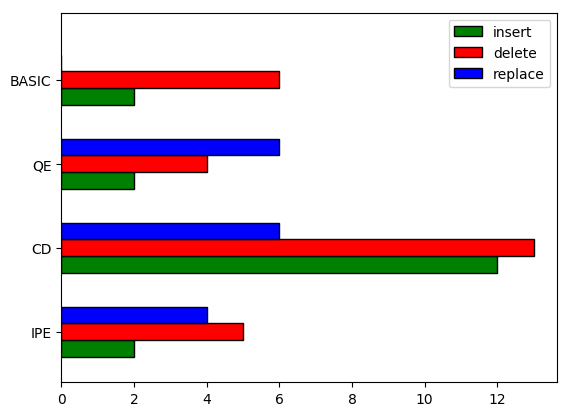

In [23]:
import matplotlib.pyplot as plt
import numpy as np


def barplot_action_types(actions_by_setting):
    plt.rcdefaults()
    fig, ax = plt.subplots()

    settings = ['IPE', 'CD', 'QE', 'BASIC']
    action_types = ['insert', 'delete', 'replace']
    action_colors = {
        'insert': 'green',
        'delete': 'red',
        'replace': 'blue'
    }
    
    ind = np.arange(len(actions_by_setting))
    width = 0.2
    
    bar_groups = defaultdict(list)
    # TODO: group label is setting
    for setting in settings:
        action_counts = actions_by_setting[setting]
        for action in action_types:
            if action in action_counts:
                bar_groups[action].append(action_counts[action])
            else:
                bar_groups[action].append(0)
    
    # TODO: colored legend by action type
    for offset, (action, counts) in enumerate(bar_groups.items()):
        ax.barh(ind + (width*offset), counts, width, 
                color=action_colors[action], 
                edgecolor='black',
                linewidth=1,
                label=action)
    
    # Add the axis labels
    #ax.set_ylabel("Editing Time (seconds)")
    #ax.set_xlabel("Sentence Id (sorted by increasing length)")
    ax.set(yticks=ind+(1*width),
           yticklabels=settings,
           ylim=[3*width - 1, len(actions_by_setting)])
    
    # Add a legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc='upper right')
    ax.legend()

barplot_action_types(user_actions_by_setting['P81'])
plt.show()


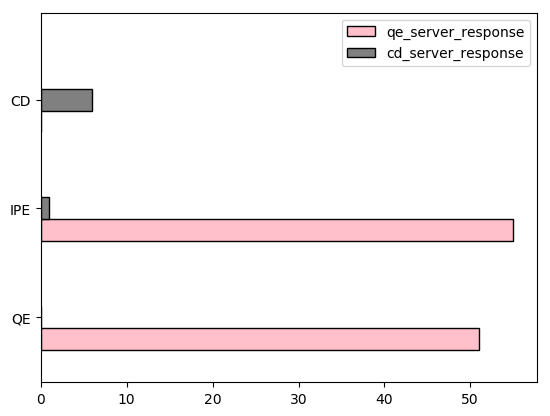

In [30]:
import matplotlib.pyplot as plt
import numpy as np


def barplot_server_responses(actions_by_setting):
    plt.rcdefaults()
    fig, ax = plt.subplots()

    settings = ['QE', 'IPE', 'CD']
    action_types = ['qe_server_response', 'cd_server_response']
    action_colors = {
        'cd_server_response': 'grey',
        'qe_server_response': 'pink',
        'confirm': 'blue'
    }
    
    ind = np.arange(len(settings))
    width = 0.2
    
    bar_groups = defaultdict(list)
    # TODO: group label is setting
    for setting in settings:
        action_counts = actions_by_setting[setting]
        for action in action_types:
            if action in action_counts:
                bar_groups[action].append(action_counts[action])
            else:
                bar_groups[action].append(0)
    
    # TODO: colored legend by action type
    for offset, (action, counts) in enumerate(bar_groups.items()):
        ax.barh(ind + (width*offset), counts, width, 
                color=action_colors[action], 
                edgecolor='black',
                linewidth=1,
                label=action)
    
    # Add the axis labels
    #ax.set_ylabel("Editing Time (seconds)")
    #ax.set_xlabel("Sentence Id (sorted by increasing length)")
    ax.set(yticks=ind+(1*width),
           yticklabels=settings,
           ylim=[3*width - 1, len(settings)])
    
    # Add a legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc='upper right')
    ax.legend()

barplot_server_responses(user_actions_by_setting['P93'])
plt.show()
